# Gradient Boosted Classifier Hyperparameter Tuning and Training 

In [0]:
# import libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.sql import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, NumericType, DateType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import col, count, mean, stddev, min, max, when, isnan, countDistinct, lit, to_timestamp, to_date, hour, avg, sum, date_sub, current_date, datediff, floor, row_number, date_format, weekofyear, year, round, substring, concat, regexp_replace, lag, last, rank, unix_timestamp, expr, ntile, rand, monotonically_increasing_id
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import optuna
import gc
from functools import partial

In [0]:
app_name = "basic-training"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

sc = spark.sparkContext

## Load data

In [0]:
train_data = spark.read.parquet("dbfs:/FileStore/tables/train_data3.parquet")
test_data = spark.read.parquet("dbfs:/FileStore/tables/test_data3.parquet")


# switch is_accident to label
train_data = train_data.withColumn("label", (col("is_accident") == 1).cast(IntegerType())).drop("is_accident")
test_data = test_data.withColumn("label", (col("is_accident") == 1).cast(IntegerType())).drop("is_accident")


In [0]:
train_data.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|   260|
|    0|166819|
+-----+------+



In [0]:
# drop labelm id columns , and EDA feature 
drop_columns = ['zipcode',"trip_date", 'vehicle_id_encoded', 'driver_id_encoded']

# drop 
drop_columns.extend(["year", "month"])

train_data = train_data.drop(*drop_columns)
test_data = test_data.drop(*drop_columns)

schema = train_data.schema

## Set up pipeline

In [0]:
# find non-numerical columns
numerical_cols = [field.name for field in schema if isinstance(field.dataType, NumericType) and field.name != "label"]
non_numerical_cols = [field.name for field in schema if not isinstance(field.dataType, NumericType)]

# Show results
print("Non-numerical columns:", non_numerical_cols)

Non-numerical columns: []


In [0]:
label_counts=train_data.groupBy('label').count()
counts = {row["label"]: row["count"] for row in label_counts.collect()}

# Assign positive and negative counts
num_positive = counts.get(1, 0)
num_negative = counts.get(0, 0)

print(f"Positive (label=1): {num_positive}")
print(f"Negative (label=0): {num_negative}")

# create POS weight
scale_pos_weight = num_negative / num_positive
print(f"Scale positive weight: {scale_pos_weight}")

train_data = train_data.withColumn(
    "class_weight",
    when(col("label") == 1, scale_pos_weight).otherwise(1.0)
)

Positive (label=1): 260
Negative (label=0): 166819
Scale positive weight: 641.6115384615384


#### Assemble Features 

In [0]:
# process data for training
feature_cols = [col for col in train_data.columns if col not in ['label', 'class_weight']]
# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform both datasets
train_prepared = assembler.transform(train_data).select("label", "features", "class_weight")
test_prepared = assembler.transform(test_data).select("label", "features")

In [0]:
# Function to make sure train/val split is stratified 
def stratified_split(df, label_col="label", train_frac=0.8, seed=42):
    fractions = df.select(label_col).distinct().withColumn(
        "fraction", F.lit(train_frac)
    ).rdd.collectAsMap()
    
    # Sample by class
    train_subset = df.stat.sampleBy(label_col, fractions, seed)
    
    # Get the validation set as the remaining data
    # Using a left anti join to get rows in df that aren't in train_subset
    validation_subset = df.join(
        train_subset, 
        on=df.columns, 
        how="left_anti"
    )
    return train_subset, validation_subset

In [0]:
train_subset, validation_subset = stratified_split(train_prepared)

### Initial Hyperparameter Tuning with All Features

In [0]:
def objective(trial):
    # Hyperparameters to tune
    max_depth = trial.suggest_int('max_depth', 3, 15)
    step_size = trial.suggest_float('step_size', 0.05, 0.3)
    subsample_rate = trial.suggest_float('subsample_rate', 0.5, 1.0)
    min_instances = trial.suggest_int('min_instances_per_node', 1, 20)
    
    # Create model with suggested hyperparameters
    gbt = GBTClassifier(
        featuresCol="features", 
        labelCol="label", 
        maxDepth=max_depth,
        stepSize=step_size,
        subsamplingRate=subsample_rate,
        minInstancesPerNode=min_instances,
        weightCol="class_weight",
    )
    
    # Create and fit pipeline
    pipeline = Pipeline(stages=[gbt])
    model = pipeline.fit(train_subset)
    
    # Evaluate on validation set
    predictions = model.transform(validation_subset)
    evaluator = BinaryClassificationEvaluator(
        labelCol="label", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderROC"
    )
    auc = evaluator.evaluate(predictions)
    
    return auc

In [0]:
study = optuna.create_study(direction='maximize', study_name='gbt_accident_prediction')

[I 2025-04-05 18:30:38,998] A new study created in memory with name: gbt_accident_prediction


In [0]:
train_subset.cache()
validation_subset.cache()

DataFrame[label: int, features: vector, class_weight: double]

In [0]:
train_subset.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1|   206|
|    0|133327|
+-----+------+



In [0]:
validation_subset.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   54|
|    0|33492|
+-----+-----+



In [0]:
study.optimize(objective, n_trials=30) 

# Hid results from notebook because output is really long 

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 18:54:52,177] Trial 1 finished with value: 0.5244093669687843 and parameters: {'max_depth': 11, 'step_size': 0.16400527992851954, 'subsample_rate': 0.5468862648657284, 'min_instances_per_node': 6}. Best is trial 1 with value: 0.5244093669687843.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 19:01:51,023] Trial 2 finished with value: 0.5681481149727301 and parameters: {'max_depth': 9, 'step_size': 0.2756128218952987, 'subsample_rate': 0.6633134778799832, 'min_instances_per_node': 4}. Best is trial 2 with value: 0.5681481149727301.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 19:04:28,540] Trial 3 finished with value: 0.6936695219643383 and parameters: {'max_depth': 3, 'step_size': 0.07897169527839405, 'subsample_rate': 0.6363004300975026, 'min_instances_per_node': 7}. Best is trial 3 with value: 0.6936695219643383.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 19:22:18,874] Trial 4 finished with value: 0.619382019365598 and parameters: {'max_depth': 14, 'step_size': 0.2364213537161448, 'subsample_rate': 0.7802880806773, 'min_instances_per_node': 3}. Best is trial 3 with value: 0.6936695219643383.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 19:33:30,280] Trial 5 finished with value: 0.5821235364111295 and parameters: {'max_depth': 11, 'step_size': 0.09730831169010508, 'subsample_rate': 0.7407347020495545, 'min_instances_per_node': 14}. Best is trial 3 with value: 0.6936695219643383.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 19:49:00,853] Trial 6 finished with value: 0.46708390284468293 and parameters: {'max_depth': 14, 'step_size': 0.2996538840475324, 'subsample_rate': 0.9004811288422889, 'min_instances_per_node': 17}. Best is trial 3 with value: 0.6936695219643383.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 19:54:39,637] Trial 7 finished with value: 0.5989241211831685 and parameters: {'max_depth': 7, 'step_size': 0.09954876225484259, 'subsample_rate': 0.7320510618933611, 'min_instances_per_node': 4}. Best is trial 3 with value: 0.6936695219643383.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:01:40,995] Trial 8 finished with value: 0.6528709454109529 and parameters: {'max_depth': 9, 'step_size': 0.1297341168347636, 'subsample_rate': 0.9419495097305894, 'min_instances_per_node': 13}. Best is trial 3 with value: 0.6936695219643383.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:16:19,630] Trial 9 finished with value: 0.6119700779843504 and parameters: {'max_depth': 15, 'step_size': 0.052586184762479296, 'subsample_rate': 0.9340228094241931, 'min_instances_per_node': 9}. Best is trial 3 with value: 0.6936695219643383.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:20:50,748] Trial 10 finished with value: 0.6229962047321416 and parameters: {'max_depth': 6, 'step_size': 0.2622000948300727, 'subsample_rate': 0.5024540045336313, 'min_instances_per_node': 2}. Best is trial 3 with value: 0.6936695219643383.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:23:26,967] Trial 11 finished with value: 0.6969483591438088 and parameters: {'max_depth': 3, 'step_size': 0.18827556652539013, 'subsample_rate': 0.6003573561922851, 'min_instances_per_node': 20}. Best is trial 11 with value: 0.6969483591438088.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:26:39,889] Trial 12 finished with value: 0.6252269751538223 and parameters: {'max_depth': 4, 'step_size': 0.2031207386419805, 'subsample_rate': 0.621023474293736, 'min_instances_per_node': 20}. Best is trial 11 with value: 0.6969483591438088.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:29:14,672] Trial 13 finished with value: 0.685421007117234 and parameters: {'max_depth': 3, 'step_size': 0.18302621144713221, 'subsample_rate': 0.6119749140314771, 'min_instances_per_node': 9}. Best is trial 11 with value: 0.6969483591438088.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:33:05,665] Trial 14 finished with value: 0.626280847609821 and parameters: {'max_depth': 5, 'step_size': 0.05104948362926892, 'subsample_rate': 0.6710601869260905, 'min_instances_per_node': 20}. Best is trial 11 with value: 0.6969483591438088.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:35:40,348] Trial 15 finished with value: 0.7120558917331279 and parameters: {'max_depth': 3, 'step_size': 0.15092628742402206, 'subsample_rate': 0.8262330776154888, 'min_instances_per_node': 12}. Best is trial 15 with value: 0.7120558917331279.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:40:59,586] Trial 16 finished with value: 0.5965600961644751 and parameters: {'max_depth': 7, 'step_size': 0.1468785238864846, 'subsample_rate': 0.8395765152875102, 'min_instances_per_node': 14}. Best is trial 15 with value: 0.7120558917331279.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:44:51,309] Trial 17 finished with value: 0.6545722914482622 and parameters: {'max_depth': 5, 'step_size': 0.2091140808431473, 'subsample_rate': 0.8362089155036465, 'min_instances_per_node': 17}. Best is trial 15 with value: 0.7120558917331279.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:47:33,545] Trial 18 finished with value: 0.7207423221023496 and parameters: {'max_depth': 3, 'step_size': 0.12594244300077537, 'subsample_rate': 0.9966825036391354, 'min_instances_per_node': 12}. Best is trial 18 with value: 0.7207423221023496.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:52:52,405] Trial 19 finished with value: 0.6566029035126154 and parameters: {'max_depth': 7, 'step_size': 0.12817708169649328, 'subsample_rate': 0.9943831779133947, 'min_instances_per_node': 12}. Best is trial 18 with value: 0.7207423221023496.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:56:41,328] Trial 20 finished with value: 0.653896342299543 and parameters: {'max_depth': 5, 'step_size': 0.1452675902319761, 'subsample_rate': 0.8515332921621452, 'min_instances_per_node': 11}. Best is trial 18 with value: 0.7207423221023496.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 20:59:51,909] Trial 21 finished with value: 0.6934030127703251 and parameters: {'max_depth': 4, 'step_size': 0.11137324798663689, 'subsample_rate': 0.9892551236663056, 'min_instances_per_node': 16}. Best is trial 18 with value: 0.7207423221023496.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 21:02:27,349] Trial 22 finished with value: 0.7039837595268742 and parameters: {'max_depth': 3, 'step_size': 0.17463647325046455, 'subsample_rate': 0.7872116888826665, 'min_instances_per_node': 9}. Best is trial 18 with value: 0.7207423221023496.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 21:05:39,786] Trial 23 finished with value: 0.679257014389285 and parameters: {'max_depth': 4, 'step_size': 0.1627859505527392, 'subsample_rate': 0.791447148306759, 'min_instances_per_node': 9}. Best is trial 18 with value: 0.7207423221023496.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 21:08:17,796] Trial 24 finished with value: 0.7428788964528845 and parameters: {'max_depth': 3, 'step_size': 0.22789612028218414, 'subsample_rate': 0.8844231267740584, 'min_instances_per_node': 10}. Best is trial 24 with value: 0.7428788964528845.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 21:12:48,444] Trial 25 finished with value: 0.6567162528586171 and parameters: {'max_depth': 6, 'step_size': 0.2289852118022254, 'subsample_rate': 0.8941770261081812, 'min_instances_per_node': 7}. Best is trial 24 with value: 0.7428788964528845.
[I 2025-04-05 21:15:31,399] Trial 26 finished with value: 0.6896030450610658 and parameters: {'max_depth': 4, 'step_size': 0.21180426215291026, 'subsample_rate': 0.9447690125459578, 'min_instances_per_node': 11}. Best is trial 24 with value: 0.7428788964528845.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 21:19:58,049] Trial 27 finished with value: 0.6641876335310587 and parameters: {'max_depth': 6, 'step_size': 0.2308784480495615, 'subsample_rate': 0.8755272314810933, 'min_instances_per_node': 15}. Best is trial 24 with value: 0.7428788964528845.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 21:29:50,114] Trial 28 finished with value: 0.6578063418129722 and parameters: {'max_depth': 11, 'step_size': 0.14458340348832366, 'subsample_rate': 0.9631806652449796, 'min_instances_per_node': 12}. Best is trial 24 with value: 0.7428788964528845.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 21:36:02,455] Trial 29 finished with value: 0.6726481945937339 and parameters: {'max_depth': 8, 'step_size': 0.08080520406455541, 'subsample_rate': 0.9034605915848197, 'min_instances_per_node': 10}. Best is trial 24 with value: 0.7428788964528845.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-05 21:39:54,082] Trial 30 finished with value: 0.6399242384029785 and parameters: {'max_depth': 5, 'step_size': 0.16248602629725115, 'subsample_rate': 0.8222016849997468, 'min_instances_per_node': 6}. Best is trial 24 with value: 0.7428788964528845.


In [0]:
optuna.visualization.plot_param_importances(study)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
optuna.visualization.plot_optimization_history(study)

In [0]:
study.best_params

{'max_depth': 3,
 'step_size': 0.22789612028218414,
 'subsample_rate': 0.8844231267740584,
 'min_instances_per_node': 10}

In [0]:
study.best_value

0.7428788964528845

In [0]:
study.trials[0].params

{'max_depth': 13,
 'step_size': 0.17293475741961029,
 'subsample_rate': 0.5056055223522435,
 'min_instances_per_node': 5}

In [0]:
study_params_and_values = [(study.params, study.values) for study in study.trials]

In [0]:
# Remove first one that failed 
study_params_and_values = study_params_and_values[1:]

## Candidate Model Selection with Cross-Validation

In [0]:
# Sort the list by the value in the second element 
sorted_results = sorted(study_params_and_values, key=lambda x: x[1][0], reverse=True)

# Print the sorted results
for i, (params, score) in enumerate(sorted_results):
    print(f"Rank {i+1}: Score = {score[0]}")
    print(f"Parameters: {params}")
    print()

Rank 1: Score = 0.7428788964528845
Parameters: {'max_depth': 3, 'step_size': 0.22789612028218414, 'subsample_rate': 0.8844231267740584, 'min_instances_per_node': 10}

Rank 2: Score = 0.7207423221023496
Parameters: {'max_depth': 3, 'step_size': 0.12594244300077537, 'subsample_rate': 0.9966825036391354, 'min_instances_per_node': 12}

Rank 3: Score = 0.7120558917331279
Parameters: {'max_depth': 3, 'step_size': 0.15092628742402206, 'subsample_rate': 0.8262330776154888, 'min_instances_per_node': 12}

Rank 4: Score = 0.7039837595268742
Parameters: {'max_depth': 3, 'step_size': 0.17463647325046455, 'subsample_rate': 0.7872116888826665, 'min_instances_per_node': 9}

Rank 5: Score = 0.6969483591438088
Parameters: {'max_depth': 3, 'step_size': 0.18827556652539013, 'subsample_rate': 0.6003573561922851, 'min_instances_per_node': 20}

Rank 6: Score = 0.6936695219643383
Parameters: {'max_depth': 3, 'step_size': 0.07897169527839405, 'subsample_rate': 0.6363004300975026, 'min_instances_per_node': 7}



In [0]:
# Create GBT classifier
gbt = GBTClassifier(
    labelCol="label",
    featuresCol="features", 
    weightCol="class_weight",
    seed=42
)

# Create parameter grid with the 5 specific best hyperparameter sets from initial tuning 
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3]) \
    .addGrid(gbt.stepSize, [0.22789612028218414, 0.12594244300077537, 0.15092628742402206, 0.17463647325046455, 0.18827556652539013]) \
    .addGrid(gbt.subsamplingRate, [0.8844231267740584, 0.9966825036391354, 0.8262330776154888, 0.7872116888826665, 0.6003573561922851]) \
    .addGrid(gbt.minInstancesPerNode, [10, 12, 12, 9, 20]) \
    .build()

# We need to ensure we get exactly the 5 combinations you want
# Let's create a filtered param grid
filtered_param_grid = []

# Define the specific hyperparameter combinations
hyperparameter_sets = [
    # Rank 1
    (3, 0.22789612028218414, 0.8844231267740584, 10),
    # Rank 2
    (3, 0.12594244300077537, 0.9966825036391354, 12),
    # Rank 3
    (3, 0.15092628742402206, 0.8262330776154888, 12),
    # Rank 4
    (3, 0.17463647325046455, 0.7872116888826665, 9),
    # Rank 5
    (3, 0.18827556652539013, 0.6003573561922851, 20)
]

# Filter the param grid to include only the specific combinations
for params in param_grid:
    md = params[gbt.maxDepth]
    ss = params[gbt.stepSize]
    sr = params[gbt.subsamplingRate]
    min_inst = params[gbt.minInstancesPerNode]
    
    if (md, ss, sr, min_inst) in hyperparameter_sets:
        filtered_param_grid.append(params)


In [0]:
# Check the label distribution
label_distribution = train_prepared.groupBy("label").count().collect()
print("Label distribution:")
for row in label_distribution:
    print(f"Label {row['label']}: {row['count']} instances")

# Create stratified folds outside the objective function
num_folds = 3

# 1. Add a random column for shuffling
train_data_shuffled = train_prepared.withColumn("random", rand(seed=42))

# 2. For each label, distribute rows evenly across folds
stratified_dfs = []

for row in label_distribution:
    label_val = row["label"]
    
    # Filter for this label
    label_df = train_data_shuffled.filter(col("label") == label_val)
    
    # Sort by random column
    label_df = label_df.orderBy("random")
    
    # Add fold column - use row_number and modulo
    window = Window.orderBy("random")
    label_df = label_df.withColumn("row_idx", row_number().over(window))
    label_df = label_df.withColumn("fold", (col("row_idx") - 1) % num_folds)
    
    # Drop temporary columns
    label_df = label_df.drop("random", "row_idx")
    
    stratified_dfs.append(label_df)

# 3. Union all the labeled dataframes
stratified_train_data = stratified_dfs[0]
for df in stratified_dfs[1:]:
    stratified_train_data = stratified_train_data.union(df)

Label distribution:
Label 1: 260 instances
Label 0: 166819 instances


In [0]:
# Create pipeline
pipeline = Pipeline(stages=[gbt])

# Create evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# Set up cross-validation
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=filtered_param_grid, 
    evaluator=evaluator,
    numFolds=num_folds,
    foldCol="fold",  
    parallelism=1,
    seed=42
)
cv_model = cv.fit(stratified_train_data)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
best_model = cv_model.bestModel.stages[-1] # Print out the parameters of the best model
print(f"Best maxDepth: {best_model.getMaxDepth()}")
print(f"Best stepSize: {best_model.getStepSize()}")
print(f"Best subsamplingRate: {best_model.getSubsamplingRate()}")
print(f"Best minInstancesPerNode: {best_model.getMinInstancesPerNode()}")  

Best maxDepth: 3
Best stepSize: 0.22789612028218414
Best subsamplingRate: 0.8844231267740584
Best minInstancesPerNode: 10


In [0]:
cv_model.avgMetrics

[0.6743526666201253,
 0.6691819013410498,
 0.6691691790704536,
 0.6664452987968199,
 0.6664458635664515,
 0.6740461174318778,
 0.6153061929664284]

### Feature Importance Analysis and Filtering


In [0]:
def get_feature_importances(model, features_col="features"):
    if hasattr(model, "featureImportances"):
        importances = model.featureImportances.toArray()
    else:
        raise ValueError(f"Model type {type(model)} doesn't support direct feature importance extraction")
    
    return importances

In [0]:
feature_importances = get_feature_importances(best_model)

In [0]:
train_prepared.schema

StructType([StructField('label', IntegerType(), True), StructField('features', VectorUDT(), True), StructField('class_weight', DoubleType(), False)])

In [0]:
feature_names  = [feature["name"] for feature in train_prepared.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]]

In [0]:
# Create a DataFrame with feature names and importances
feature_importance_list = [(name, float(importance)) for name, importance in zip(feature_names, feature_importances)]
feature_importances_df = spark.createDataFrame(feature_importance_list, ["feature", "importance"])

# Sort by importance in descending order
feature_importances_df = feature_importances_df.orderBy("importance", ascending=False)

In [0]:
# Check for importance of 0 
feature_importances_df.filter(feature_importances_df.importance == 0).count()

86

In [0]:
display(feature_importances_df.filter(feature_importances_df.importance == 0))

feature,importance
last_has_issues,0.0
ratio_seat_belt_violation_roll15d_per_year,0.0
group_nc__griffin_hook_trucks,0.0
ratio_tailgating_roll15d_per_year,0.0
crash_roll15d,0.0
ratio_unsafe_lane_change_roll15d_per_year,0.0
group_tn__maxwell_septic,0.0
ratio_total_events_per_trip_roll15d_per_year,0.0
vehicle_rolling_15trip_num_issues,0.0
ratio_trip_ts_roll15d_per_year,0.0


In [0]:
# Find features with zero or near-zero importance
threshold = 1e-10
zero_importance_features_df = feature_importances_df.filter(feature_importances_df.importance <= threshold)

# Collect the list of zero importance features
zero_importance_features = [row.feature for row in zero_importance_features_df.collect()]

print(f"Found {len(zero_importance_features)} features with zero importance")
if zero_importance_features:
    print("Sample of zero importance features:", zero_importance_features[:5])

Found 86 features with zero importance
Sample of zero importance features: ['last_has_issues', 'vehicle_rolling_15trip_num_issues', 'vehicle_rolling_15trip_issues_distance', 'vehicle_rolling_15trip_issues_minutes', 'vehicle_rolling_15trip_issues_events']


In [0]:
# Filter out zero importance features
important_feature_cols = [col for col in feature_cols if col not in zero_importance_features]

# Create a new VectorAssembler with only the important features
filtered_assembler = VectorAssembler(inputCols=important_feature_cols, outputCol="features")

# Transform both datasets with the filtered features
train_prepared_filtered = filtered_assembler.transform(train_data).select("label", "features", "class_weight")
test_prepared_filtered = filtered_assembler.transform(test_data).select("label", "features")


### Refined Hyperparameter Tuning on Filtered Dataset


In [0]:
num_folds=3

In [0]:
# Check the label distribution
label_distribution = train_prepared_filtered.groupBy("label").count().collect()
print("Label distribution:")
for row in label_distribution:
    print(f"Label {row['label']}: {row['count']} instances")

# Create stratified folds outside the objective function
num_folds = 3

# Same stratification process as before 
train_data_shuffled = train_prepared_filtered.withColumn("random", rand(seed=42))
stratified_dfs = []

for row in label_distribution:
    label_val = row["label"]

    label_df = train_data_shuffled.filter(col("label") == label_val)
    label_df = label_df.orderBy("random")
    
    window = Window.orderBy("random")
    label_df = label_df.withColumn("row_idx", row_number().over(window))
    label_df = label_df.withColumn("fold", (col("row_idx") - 1) % num_folds)
    
    label_df = label_df.drop("random", "row_idx")
    
    stratified_dfs.append(label_df)

stratified_train_data = stratified_dfs[0]
for df in stratified_dfs[1:]:
    stratified_train_data = stratified_train_data.union(df)

print("\nOverall fold distribution:")
stratified_train_data.groupBy("fold").count().orderBy("fold").show()

print("\nFold distribution by label:")
stratified_train_data.groupBy("fold", "label").count().orderBy("fold", "label").show(100)

Label distribution:
Label 1: 260 instances
Label 0: 166819 instances

Overall fold distribution:
+----+-----+
|fold|count|
+----+-----+
|   0|55694|
|   1|55693|
|   2|55692|
+----+-----+


Fold distribution by label:
+----+-----+-----+
|fold|label|count|
+----+-----+-----+
|   0|    0|55607|
|   0|    1|   87|
|   1|    0|55606|
|   1|    1|   87|
|   2|    0|55606|
|   2|    1|   86|
+----+-----+-----+



In [0]:
def cv_objective(trial, train_data_with_folds, num_folds=3):
    # Get hyperparameters from Optuna
    step_size = trial.suggest_float('step_size', 0.12, 0.3)
    subsample_rate = trial.suggest_float('subsample_rate', 0.6, 1.0)
    min_instances = trial.suggest_int('min_instances_per_node', 9, 20)
    
    # Create base model with suggested hyperparameters
    gbt = GBTClassifier(
        featuresCol="features", 
        labelCol="label", 
        maxDepth=3,
        stepSize=step_size,
        subsamplingRate=subsample_rate,
        minInstancesPerNode=min_instances,
        weightCol="class_weight",
    )
    
    # Create pipeline
    pipeline = Pipeline(stages=[gbt])
    
    # Create evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="label", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderROC"
    )
    
    # Set up cross-validation
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=[{}], 
        evaluator=evaluator,
        numFolds=num_folds,
        foldCol="fold",  
        parallelism=1,
        seed=42
    )
    
    # Run cross-validation
    cv_model = cv.fit(train_data_with_folds)
    
    # Get average metric across all folds
    avg_metric = cv_model.avgMetrics[0]
    
    return avg_metric

# pass the stratified data
def objective_func(trial):
    return cv_objective(trial, stratified_train_data, num_folds=3)

In [0]:
# Create study object
study = optuna.create_study(direction="maximize")

study.optimize(objective_func, n_trials=10)

[I 2025-04-06 15:04:25,976] A new study created in memory with name: no-name-4654471c-b6d3-44e2-b810-97cdabe8cd10


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 15:13:23,788] Trial 0 finished with value: 0.6805324899936469 and parameters: {'step_size': 0.26139811980844574, 'subsample_rate': 0.9006490494294722, 'min_instances_per_node': 12}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 15:22:17,010] Trial 1 finished with value: 0.6773600112892705 and parameters: {'step_size': 0.15180290080336026, 'subsample_rate': 0.9119571386066195, 'min_instances_per_node': 17}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 15:31:07,565] Trial 2 finished with value: 0.6507202419334549 and parameters: {'step_size': 0.28173182270977243, 'subsample_rate': 0.9270042893960543, 'min_instances_per_node': 14}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 15:39:57,618] Trial 3 finished with value: 0.6622461650983679 and parameters: {'step_size': 0.1960915767141762, 'subsample_rate': 0.6593576303624354, 'min_instances_per_node': 9}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 15:48:48,252] Trial 4 finished with value: 0.6757780703879214 and parameters: {'step_size': 0.20132630456022219, 'subsample_rate': 0.9966850075265519, 'min_instances_per_node': 18}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 15:57:34,873] Trial 5 finished with value: 0.6690939826001565 and parameters: {'step_size': 0.19610589845491289, 'subsample_rate': 0.7293680585565592, 'min_instances_per_node': 12}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 16:06:27,997] Trial 6 finished with value: 0.6542091077642491 and parameters: {'step_size': 0.28197539463764937, 'subsample_rate': 0.7657553371737382, 'min_instances_per_node': 20}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 16:15:25,750] Trial 7 finished with value: 0.6712950996456559 and parameters: {'step_size': 0.13230586304870431, 'subsample_rate': 0.6516526940336156, 'min_instances_per_node': 20}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 16:24:16,601] Trial 8 finished with value: 0.6597390935964283 and parameters: {'step_size': 0.23917847432938055, 'subsample_rate': 0.7658890745638423, 'min_instances_per_node': 20}. Best is trial 0 with value: 0.6805324899936469.


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-04-06 16:33:14,372] Trial 9 finished with value: 0.663790916353789 and parameters: {'step_size': 0.28855651990231784, 'subsample_rate': 0.6340867343349439, 'min_instances_per_node': 18}. Best is trial 0 with value: 0.6805324899936469.


In [0]:
# Get the best hyperparameters from the study
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")
print(f"Best metric value: {study.best_value}")

Best hyperparameters: {'step_size': 0.26139811980844574, 'subsample_rate': 0.9006490494294722, 'min_instances_per_node': 12}
Best metric value: 0.6805324899936469


In [0]:
# Create the best model with optimal hyperparameters
best_gbt = GBTClassifier(
    featuresCol="features", 
    labelCol="label", 
    maxDepth=3,
    stepSize=best_params['step_size'],
    subsamplingRate=best_params['subsample_rate'],
    minInstancesPerNode=best_params['min_instances_per_node'],
    weightCol="class_weight"
)

In [0]:
# Create and fit the final pipeline
best_pipeline = Pipeline(stages=[best_gbt])
best_model = best_pipeline.fit(train_prepared_filtered)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

auprc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedPrecision"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedRecall"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="f1"
)

In [0]:
train_predictions = best_model.transform(train_prepared_filtered )

In [0]:
auprc = auprc_evaluator.evaluate(train_predictions)
auc = auc_evaluator.evaluate(train_predictions)
precision = precision_evaluator.evaluate(train_predictions)
recall = recall_evaluator.evaluate(train_predictions)
f1 = f1_evaluator.evaluate(train_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")
print(f"AUPRC: {auprc}")

Precision: 0.9981907119004729
Recall: 0.8149557993524023
F1 Score: 0.8965189101846868
AUC: 0.9162940418611235
AUPRC: 0.016974585551475827


In [0]:
# Calculate metrics using PySpark DataFrame operations
from pyspark.sql.functions import sum, when, col

# Calculate TP, FP, TN, FN using DataFrame operations
metrics = train_predictions.select(
    sum(when(col("prediction") == 1.0, 1).otherwise(0)).alias("predicted_positives"),
    sum(when(col("label") == 1.0, 1).otherwise(0)).alias("actual_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 1.0), 1).otherwise(0)).alias("true_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 0.0), 1).otherwise(0)).alias("false_positives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 0.0), 1).otherwise(0)).alias("true_negatives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 1.0), 1).otherwise(0)).alias("false_negatives")
).collect()[0]

# Extract values from the Row
predicted_positives = metrics.predicted_positives
actual_positives = metrics.actual_positives
actual_negatives = train_predictions.count() - actual_positives
true_positives = metrics.true_positives
false_positives = metrics.false_positives
true_negatives = metrics.true_negatives
false_negatives = metrics.false_negatives

# Calculate TPR, FPR, and PPV
tpr = float(true_positives) / float(actual_positives) if actual_positives > 0 else 0.0
fpr = float(false_positives) / float(actual_negatives) if actual_negatives > 0 else 0.0
ppv = float(true_positives) / float(predicted_positives) if predicted_positives > 0 else 0.0

In [0]:
print(f"TPR (True Positive Rate): {tpr:.4f}")
print(f"FPR (False Positive Rate): {fpr:.4f}")
print(f"PPV (Positive Predictive Value): {ppv:.4f}")

TPR (True Positive Rate): 0.8615
FPR (False Positive Rate): 0.1851
PPV (Positive Predictive Value): 0.0072


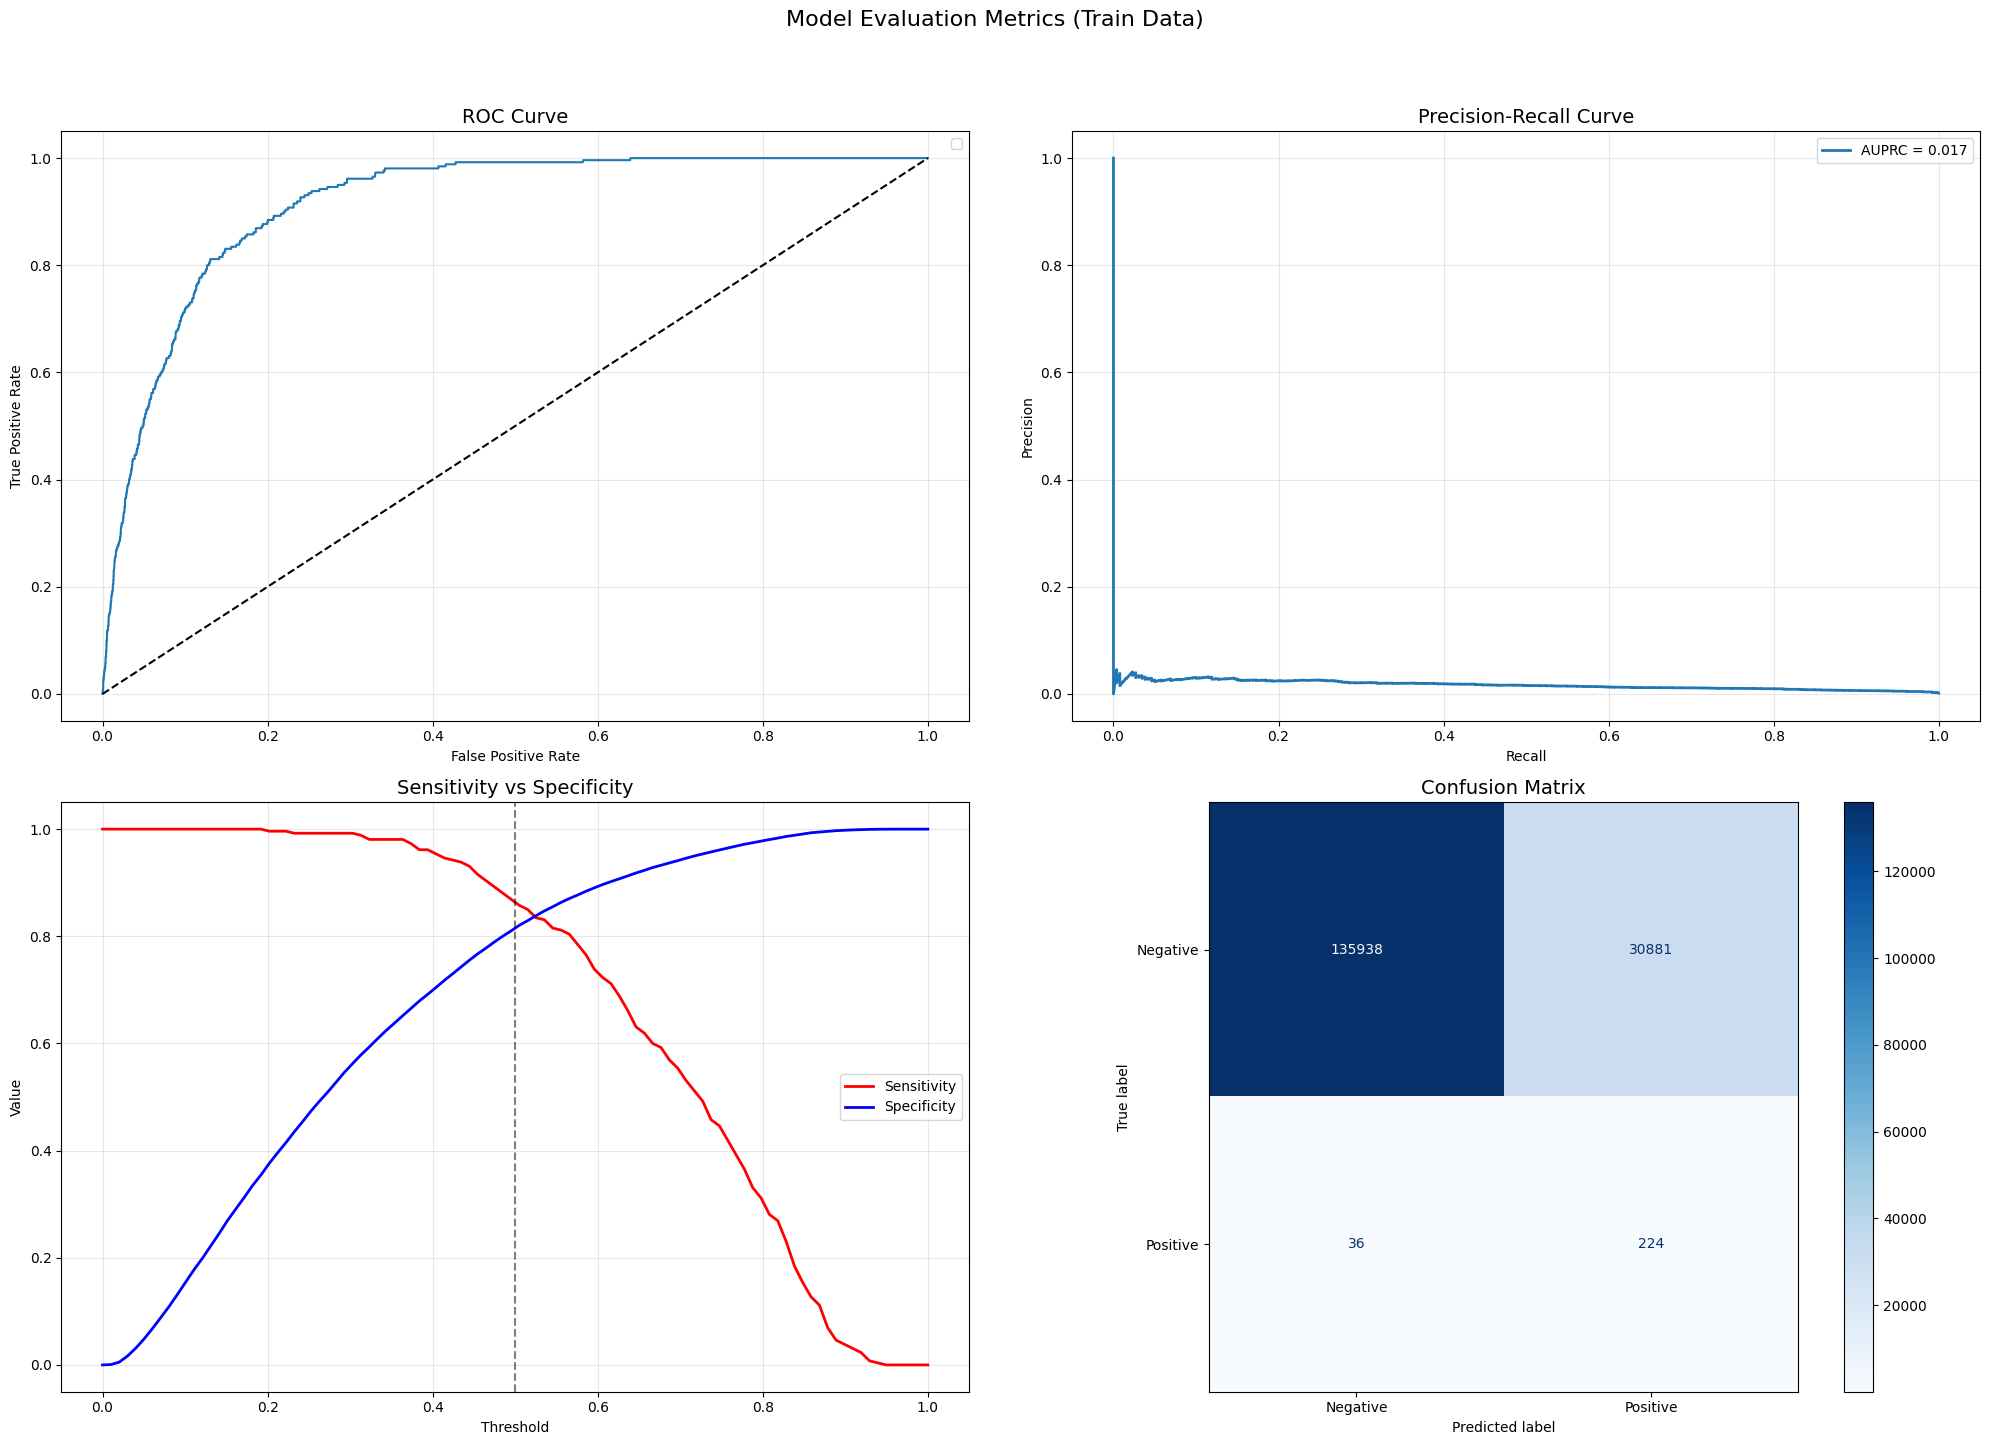

In [0]:
pandas_df = train_predictions.select("label", "prediction", "probability").toPandas()
pandas_df["probability_pos"] = pandas_df["probability"].apply(lambda x: x[1])

# Get data for calculations
y_true = pandas_df["label"]
y_pred = pandas_df["prediction"]
y_prob = pandas_df["probability_pos"]

threshold = 0.5 

# Multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)

ax1 = plt.subplot(2, 2, 1)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_prob)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'AUPRC = {auprc:.3f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Sensitivity vs Specificity at different thresholds
thresholds_range = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

for t in thresholds_range:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
    
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(thresholds_range, sensitivity, 'r-', linewidth=2, label='Sensitivity')
ax3.plot(thresholds_range, specificity, 'b-', linewidth=2, label='Specificity')
ax3.axvline(x=threshold, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Value')
ax3.set_title('Sensitivity vs Specificity', fontsize=14)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

ax4 = plt.subplot(2, 2, 4)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(ax=ax4, cmap='Blues', values_format='d')
ax4.set_title('Confusion Matrix', fontsize=14)


plt.suptitle("Model Evaluation Metrics (Train Data)", fontsize=16, y=0.98)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])

In [0]:
test_predictions = best_model.transform(test_prepared_filtered )

In [0]:
auprc = auprc_evaluator.evaluate(test_predictions)
auc = auc_evaluator.evaluate(test_predictions)
precision = precision_evaluator.evaluate(test_predictions)
recall = recall_evaluator.evaluate(test_predictions)
f1 = f1_evaluator.evaluate(test_predictions)

In [0]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")
print(f"AUPRC: {auprc}")

Precision: 0.9954207791491896
Recall: 0.7799474277131054
F1 Score: 0.8742029869681178
AUC: 0.5591897169183894
AUPRC: 0.0029287603291472683


In [0]:
# Calculate metrics using PySpark DataFrame operations
from pyspark.sql.functions import sum, when, col

# Calculate TP, FP, TN, FN using DataFrame operations
metrics = test_predictions.select(
    sum(when(col("prediction") == 1.0, 1).otherwise(0)).alias("predicted_positives"),
    sum(when(col("label") == 1.0, 1).otherwise(0)).alias("actual_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 1.0), 1).otherwise(0)).alias("true_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 0.0), 1).otherwise(0)).alias("false_positives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 0.0), 1).otherwise(0)).alias("true_negatives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 1.0), 1).otherwise(0)).alias("false_negatives")
).collect()[0]

# Extract values from the Row
predicted_positives = metrics.predicted_positives
actual_positives = metrics.actual_positives
actual_negatives = test_predictions.count() - actual_positives
true_positives = metrics.true_positives
false_positives = metrics.false_positives
true_negatives = metrics.true_negatives
false_negatives = metrics.false_negatives

# Calculate TPR, FPR, and PPV
tpr = float(true_positives) / float(actual_positives) if actual_positives > 0 else 0.0
fpr = float(false_positives) / float(actual_negatives) if actual_negatives > 0 else 0.0
ppv = float(true_positives) / float(predicted_positives) if predicted_positives > 0 else 0.0

In [0]:
print(f"TPR (True Positive Rate): {tpr:.4f}")
print(f"FPR (False Positive Rate): {fpr:.4f}")
print(f"PPV (Positive Predictive Value): {ppv:.4f}")

TPR (True Positive Rate): 0.2778
FPR (False Positive Rate): 0.2189
PPV (Positive Predictive Value): 0.0030


Even though an AUC of 0.86 sounds pretty good, the model has a positive predictive values of 0.0027, meaning that only 0.27% a true positive prediction is correct. A 23.65% false positive rate seems reasonable until you realize that with such a large negative class, this translates to over 10,600 false positives compared to only 29 true positives.

In [0]:
feature_importances = get_feature_importances(best_model.stages[-1])

# Create a DataFrame with feature names and importances
feature_importance_list = [(name, float(importance)) for name, importance in zip(feature_names, feature_importances)]
feature_importances_df = spark.createDataFrame(feature_importance_list, ["feature", "importance"])

# Sort by importance in descending order
feature_importances_df = feature_importances_df.orderBy("importance", ascending=False)

In [0]:
# Show most importsnt features
display(feature_importances_df.limit(25))

feature,importance
rolling_15trip_avg_speed_mph,0.05871705251883081
rolling_15day_total_distance,0.048208701247375564
driving_year_since_first_trip,0.04492437443749487
vehicle_inspection_rate,0.03931892910054573
vehicle_rolling_15trip_num_inspect,0.03585372417336555
vehicle_rolling_15trip_insp_minutes,0.0347828518368149
days_since_last_inspection,0.03355275817894705
low_roll15d,0.0320200150577962
prev_trip_date_distance,0.031978196217895626
cell_phone_roll15d,0.02999463370336512


The performance on the test set was much higher than what we expected from cross-validation. We think this could be due to two reasons. First, the model might have overfit to the validation folds during cross-validation, particularly given the extreme class imbalance observed in our data. As shown in our fold distribution, each fold contained approximately 55,600 examples of class 0 and only 86-87 examples of class 1, creating a significant imbalance ratio of roughly 640:1. The test set maintained a similar imbalance with 166,819 examples of class 0 and 260 examples of class 1. With such severe class imbalance, the model likely struggled to generalize properly during cross-validation, leading to inconsistent performance across folds.

Secondly, the training/validation data and the test data might come from different distributions. For example, the test set may contain more representative or easier examples compared to the training data because adherence to the Motive API has increased with driver incentives, resulting in more high-quality complete data.

The most important features in our model are total_events_per_trip_roll15d (safety events flagged by Motive), cell_phone_roll15d (cell phone usage), rolling_15trip_avg_speed_mph (speed), and vehicle_rolling_15trip_num_inspect (number of vehicle inspections), which aligns with what we would expect to be associated with crashes.

We have found no evidence of data leakage in the variables, but before something like this is put into production, we would want to run it silently in the background and evaluate its performance in real time.

In [0]:
test_predictions

DataFrame[label: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [0]:
pandas_df = test_predictions.select("label", "prediction", "probability").toPandas()
pandas_df["probability_pos"] = pandas_df["probability"].apply(lambda x: x[1])

# Get data for calculations
y_true = pandas_df["label"]
y_pred = pandas_df["prediction"]
y_prob = pandas_df["probability_pos"]

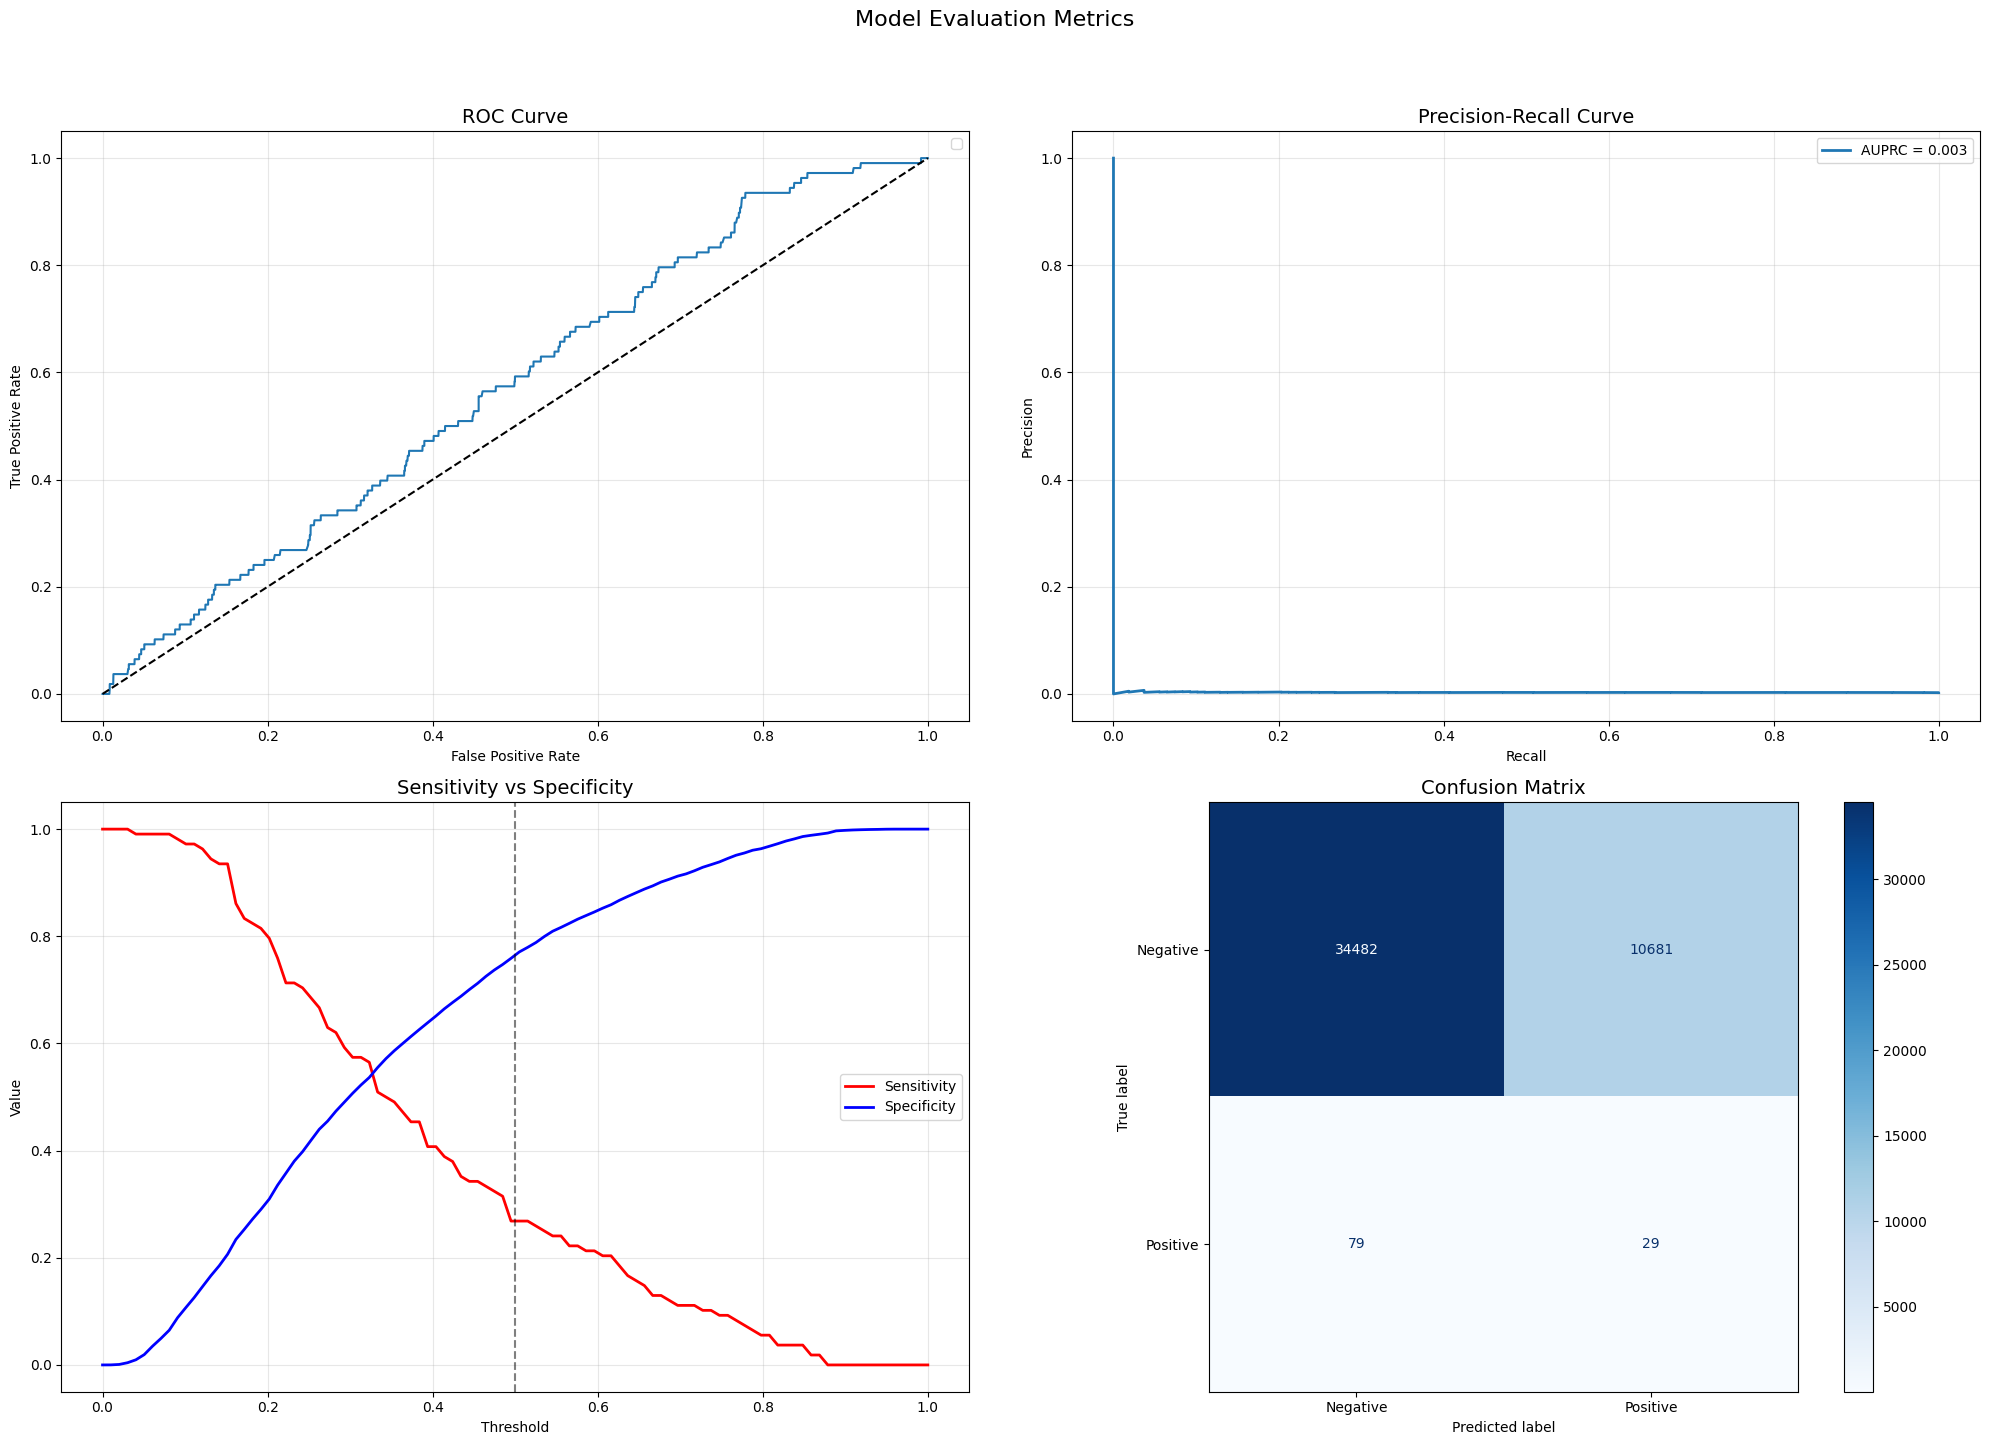

In [0]:
threshold = 0.5 

# Multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)

ax1 = plt.subplot(2, 2, 1)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_prob)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'AUPRC = {auprc:.3f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Sensitivity vs Specificity at different thresholds
thresholds_range = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

for t in thresholds_range:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
    
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(thresholds_range, sensitivity, 'r-', linewidth=2, label='Sensitivity')
ax3.plot(thresholds_range, specificity, 'b-', linewidth=2, label='Specificity')
ax3.axvline(x=threshold, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Value')
ax3.set_title('Sensitivity vs Specificity', fontsize=14)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

ax4 = plt.subplot(2, 2, 4)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(ax=ax4, cmap='Blues', values_format='d')
ax4.set_title('Confusion Matrix', fontsize=14)


plt.suptitle("Model Evaluation Metrics", fontsize=16, y=0.98)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])

In [0]:
# Save train

In [0]:
# Save stratified_train_data to dbfs:/FileStore/tables/stratified_train_data


# Save predictions test_predictions to dbfs:/FileStore/tables/best_model_test_predictions

# Save model to Workspace '/Workspace/Users/isabel.c.arvelo@vanderbilt.edu'


In [0]:
# Save stratified_train_data 
stratified_train_data.write.format("parquet").save("dbfs:/FileStore/tables/stratified_train_data")

# Save predictions
test_predictions.write.format("parquet").save("dbfs:/FileStore/tables/best_model_test_predictions")